### Code for a 2D Hydrodynamics Simulation of a Sedov Blast

In [1]:
#necessary libraries imported 
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize 

In [2]:
class FluidVars:
    """A simple container that holds the integer indicies we will use to
    refer to the different fluid components"""
    
    def __init__(self, gamma=1.4, C=0.8):
        self.nvar = 4                           #number of variables used in our Euler equation = 4 
    
        # conserved variables
        self.urho = 0                           #density 
        self.umx = 1                            #momentum in the x direction 
        self.umy = 2                            #momentum in the y direction 
        self.uener = 3                          #energy
    
        # primitive variables
        self.qrho = 0                           #density 
        self.qux = 1                            #velocity in the x direction 
        self.quy = 2                            #velocity in the y direction
        self.qp = 3                             #pressure 
    
        # EOS gamma
        self.gamma = gamma       
        
        # CFL number
        self.C = C 


class FVGrid:
    """The main finite-volume grid class for holding our fluid state."""
    
    def __init__(self, nx, ng, xmin=-1.0, xmax=1.0, ymin=-1.0, ymax=1.0, vars=None):
        '''Creates a grid that runs from xmin to xmax, ymin to ymax, consisting of nx number of points, and ng number of ghost cells on each end.'''

        self.xmin = xmin
        self.xmax = xmax
        
        self.ymin = ymin
        self.ymax = ymax
        
        self.ng = ng
        self.nx = nx        #nx = ny #assuming a symmetric grid 

        #to determine the location of the actual grid without the ghost cells. 
        self.lo = ng        
        self.hi = ng+nx-1   

        # physical coords -- cell-centered [hence dx= (max - min)/n]
        self.dx = (xmax - xmin)/(nx)
        self.dy = (ymax - ymin)/(nx)
        
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx        #x coordinates
        self.y = ymin + (np.arange(nx+2*ng)-ng+0.5)*self.dy        #y coordinates 
        
        self.v = vars      #variable index

    def scratch_array(self, nc=1): 
        """Returns a scratch array dimensioned for our grid.
        A 3 dimensional array is created, with the x and y coordinates and an array of variables. (x, y, vars)"""
        return np.squeeze(np.zeros((self.nx+2*self.ng, self.nx+2*self.ng, nc), dtype=np.float64))

    def fill_BCs(self, atmp):
        """ fill all ghost cells with zero-gradient boundary conditions """
        if atmp.ndim == 3:                                         #since our grid is 2D. but the scratch array is 3 dimensional       
            for n in range(atmp.shape[-1]):
                atmp[0:self.lo, :, n] = atmp[self.lo, :, n]
                atmp[:, self.lo-1, n] = atmp[:, self.lo, n]
                atmp[:, self.lo-2, n] = atmp[:, self.lo, n]
                
                atmp[self.hi+1:, :, n] = atmp[self.hi, :, n]
                atmp[:, self.hi+1, n] = atmp[:, self.hi, n] 
                atmp[:, self.hi+2, n] = atmp[:, self.hi, n] 
        
def cons_to_prim(g, U):
    """take a conservative state U and return the corresponding primitive
    variable state as a new array."""
    q = g.scratch_array(nc=g.v.nvar)
    q[:, :, g.v.qrho] = U[:, :, g.v.urho]                                                             #rho
    q[:, :, g.v.qux] = U[:, :, g.v.umx]/U[:, :, g.v.urho]                                             #ux    
    q[:, :, g.v.quy] = U[:, :, g.v.umy]/U[:, :, g.v.urho]                                             #uy
    rhoe = U[:, :, g.v.uener] - 0.5*q[:, :, g.v.qrho]*(q[:, :, g.v.qux]**2 + q[:, :, g.v.quy]**2)        
    q[:, :, g.v.qp] = rhoe*(g.v.gamma - 1.0)                                                          #p
    return q


def states(g, U):
    """Returns the left, right and the up and down state of each interface considered in the x and the y direction
    """

    #converting each conservative to primitives 
    qx = cons_to_prim(g, U)
    qy = cons_to_prim(g, U)
 
    #construct empty arrays for the slopes
    dqx = g.scratch_array(nc=g.v.nvar)
    dqy = g.scratch_array(nc=g.v.nvar) 

    #compute the slopes for each variable
    for n in range(g.v.nvar):  
        
        #for the xaxis 
        dl = g.scratch_array()
        dr = g.scratch_array()

        dl[g.lo-1:g.hi+2, :] = qx[g.lo:g.hi+3, :, n] - qx[g.lo-1:g.hi+2, :, n]
        dr[g.lo-1:g.hi+2, :] = qx[g.lo-1:g.hi+2, :, n] - qx[g.lo-2:g.hi+1, :, n]

        #minmod() limiter at the extremities of the grid to prevent overshooting
        d1 = np.where(np.fabs(dl) < np.fabs(dr), dl, dr)
        dqx[:, :, n] = np.where(dl*dr > 0.0, d1, 0.0)

        #for the yaxis 
        du = g.scratch_array()
        dd = g.scratch_array()
        
        #old
        dd[:, g.lo-1:g.hi+2] = qy[:, g.lo:g.hi+3, n] - qy[:, g.lo-1:g.hi+2, n]
        du[:, g.lo-1:g.hi+2] = qy[:, g.lo-1:g.hi+2, n] - qy[:, g.lo-2:g.hi+1, n] 

        #minmod() limiter at the extremities of the grid to prevent overshooting
        d2 = np.where(np.fabs(dd) < np.fabs(du), dd, du)
        dqy[:, :, n] = np.where(dd*du > 0.0, d2, 0.0)

    #now make the states (x axis)
    q_l = g.scratch_array(nc=g.v.nvar)
    q_l[g.lo:g.hi+2, :, :] = qx[g.lo-1:g.hi+1, :, :] + 0.5*dqx[g.lo-1:g.hi+1, :, :]

    q_r = g.scratch_array(nc=g.v.nvar)
    q_r[g.lo:g.hi+2, :, :] = qx[g.lo:g.hi+2, :, :] - 0.5*dqx[g.lo:g.hi+2, :, :]

    #now making the states (yaxis)           
    q_d = g.scratch_array(nc=g.v.nvar)
    q_d[:, g.lo:g.hi+2, :] = qy[:, g.lo-1:g.hi+1, :] + 0.5*dqy[:, g.lo-1:g.hi+1, :]

    q_u = g.scratch_array(nc=g.v.nvar)
    q_u[:, g.lo:g.hi+2, :] = qy[:, g.lo:g.hi+2, :] - 0.5*dqy[:, g.lo:g.hi+2, :]

    return q_l, q_r, q_d, q_u


def cons_flux_forx(state_x, state_y, v):
    """ given an interface state, return the conservative flux this is for the x axis"""

    #the conservative flux is stored in this array after computing for each variable
    flux = np.zeros((v.nvar), dtype=np.float64)

    flux[v.urho] = state_x.rho * state_x.u    
    flux[v.umx] = flux[v.urho] * state_x.u + state_x.p  
    flux[v.umy] = flux[v.urho] * state_y.u    
    flux[v.uener] = (0.5 * state_x.rho * (state_x.u**2 + state_y.u**2) +  state_x.p/(v.gamma - 1.0) + state_x.p) * state_x.u
    
    return flux


def cons_flux_fory(state_y, state_x, v):
    """ given an interface state, return the conservative flux this is for the y axis"""

    #the conservative flux is stored in this array after computing for each variable
    flux = np.zeros((v.nvar), dtype=np.float64)

    flux[v.urho] = state_y.rho * state_y.u    
    flux[v.umx] = flux[v.urho] * state_x.u   
    flux[v.umy] = flux[v.urho] * state_y.u + state_y.p    
    flux[v.uener] = (0.5 * state_y.rho * (state_x.u**2 + state_y.u**2) +  state_y.p/(v.gamma - 1.0) + state_y.p) * state_y.u
    
    return flux

In [3]:
#importing the Riemann Solver required to solve the Riemann Problem

import importlib
import reimann_solver as re

importlib.reload(re)

<module 'reimann_solver' from '/home/divyanshi/Comp Astro Project/reimann_solver.py'>

In [4]:
def make_flux_divergence(g, U): 
    """Obtains the states on either side of the interface in order to compute the interface state. 
    Returns a matrix of the conservative fluxes in each direction."""
    
    # get the states
    q_l, q_r, q_d, q_u= states(g, U)

    # now solve the Riemann problem
    flux_x = g.scratch_array(nc=g.v.nvar)
    flux_y = g.scratch_array(nc=g.v.nvar)

    #to solve for the interface state in each cell of the grid 
    for i in range(g.lo, g.hi+2):
        for j in range(g.lo, g.hi+2):
            sl = re.State(rho=q_l[i, j, g.v.qrho], u=q_l[i, j, g.v.qux], p=q_l[i, j, g.v.qp])
            sr = re.State(rho=q_r[i, j, g.v.qrho], u=q_r[i, j, g.v.qux], p=q_r[i, j, g.v.qp])
            sd = re.State(rho=q_d[i, j, g.v.qrho], u=q_d[i, j, g.v.quy], p=q_d[i, j, g.v.qp])
            su = re.State(rho=q_u[i, j, g.v.qrho], u=q_u[i, j, g.v.quy], p=q_u[i, j, g.v.qp])

            #Solving the Riemann problem in the x and y direction simultaneously. 
            rpx = re.RiemannProblem(sl, sr, gamma=g.v.gamma)
            rpx.find_star_state()
            q_int_x = rpx.sample_solution()
    
            rpy = re.RiemannProblem(sd, su, gamma=g.v.gamma)
            rpy.find_star_state()
            q_int_y = rpy.sample_solution()
    
            #computing the flux at the interface state in both directions 
            flux_x[i, j, :] = cons_flux_forx(q_int_x, q_int_y, g.v) 
            flux_y[i,j , :] = cons_flux_fory(q_int_y, q_int_x, g.v) 

    Ax = g.scratch_array(nc=g.v.nvar)                                            #flux matrix in the x direction
    Ay = g.scratch_array(nc=g.v.nvar)                                            #flux matrix in the y direction

    #to compute for the advection of each variable 
    for n in range(g.v.nvar):
        Ax[g.lo:g.hi+1, :, n] = (flux_x[g.lo:g.hi+1, :, n] -
                             flux_x[g.lo+1:g.hi+2, :, n]) / g.dx
        
        Ay[:, g.lo:g.hi+1, n] = (flux_y[:, g.lo:g.hi+1, n] -
                             flux_y[:, g.lo+1:g.hi+2, n]) / g.dy
    return Ax, Ay



def timestep(g, U):
    """computes the timesteps required for the update of variables"""
    
    qx = cons_to_prim(g, U)
    qy = cons_to_prim(g, U)

    #for the x direction
    #compute the sound speed
    cx = g.scratch_array()                                                     #assuming the sound speed to remain constant throughout the grid 
    cx[g.lo:g.hi+1, :] = np.sqrt(g.v.gamma *
                             qx[g.lo:g.hi+1, :,  g.v.qp] /
                             qx[g.lo:g.hi+1, :,  g.v.qrho])

    #timmestep 
    dtx = g.v.C * g.dx / (np.abs(qx[g.lo:g.hi+1, :, g.v.qux]) +
                         cx[g.lo:g.hi+1, :]).max()

    #for the y direction
    #compute the sound speed 
    cy = g.scratch_array()
    cy[:, g.lo:g.hi+1] = np.sqrt(g.v.gamma *
                             qy[:, g.lo:g.hi+1, g.v.qp] /
                             qy[:, g.lo:g.hi+1, g.v.qrho])
    #timestep
    dty = g.v.C * g.dx / (np.abs(qy[:, g.lo:g.hi+1, g.v.quy]) +
                         cy[:, g.lo:g.hi+1]).max()

    #since the grid is symmetric and the propagation is considered with the same speed, 
    #for generalisation, the minimum of the two timesteps computed is taken, implying the consideration 
    #of the fastest propagation. 

    dt= min(dtx, dty)
    return dt


def mol_solve(nx, C=0.8, tmax=1.0, init_cond=None):     
    """Perform 2nd order MOL integration of the Euler equations.
    You need to pass in a function for(grid) that returns the 
    initial conserved fluid state."""

    v = FluidVars(C=C)                                 #Assigns indices to the variables and values to the constants 
    
    grid = FVGrid(nx, ng=2, vars=v)                    #empty grid is created
    
    U = init_cond(grid)                                #creates a grid with values based on the initial conditions specified   
    
    t = 0.0
    while t < tmax:
        dt = timestep(grid, U)
        if t + dt > tmax:
            dt = tmax - t

        grid.fill_BCs(U)
        k1x, k1y = make_flux_divergence(grid, U)     
        
        U_tmp= grid.scratch_array(nc=v.nvar)
        for n in range(v.nvar):
            U_tmp[:, :, n] = U[:, :, n] + 0.5 * dt * (k1x[:, :, n] + k1y[:, : , n])
             

        k2x, k2y = make_flux_divergence(grid, U_tmp) 
       
        for n in range(v.nvar):
            U[:, :, n] += dt * (k2x[:, :, n]   +  k2y[:, :, n])

        t += dt
    
    return grid, U

In [5]:
def sedov_blast(g):
    """Define the initial conditions of the sedov blast and returns the grid on which the blast is computed. 
    An empty grid U is initialised with values for density, velocities in the x and y directions and the pressure"""

    #empty grid
    U = g.scratch_array(nc=g.v.nvar)

    #initial values for the entirety of the grid
    rho = 1.0 
    ux = 0.0        
    uy = 0.0

    #pressure towards the origin is kept higher in order to trigger the outflow
    p_in = 1.0
    #pressure in the rest of the grid 
    p_out = 0.01
    
    #cells that can be identified as the x and y coordinates 
    x_coord=g.x 
    y_coord=g.y 

    #assigning the cells of the grid the values of the variables 
    for x in range(len(x_coord)): 
        for y in range(len(y_coord)):  
            if np.sqrt((x- 26)**2 + (y- 26)**2) <= 10:     #initial conditions responsible to trigger the outflow, placed in the center of the grid
                U[x, y, g.v.urho] = rho 
                U[x, y, g.v.umx] = rho*ux
                U[x, y, g.v.umy] = rho*uy
                U[x, y, g.v.uener] = p_in/(g.v.gamma - 1.0) + 0.5 * rho * (ux**2 + uy**2)
               
            else:                                         #initial conditions in the rest of the grid. 
                U[x, y, g.v.urho] = rho 
                U[x, y, g.v.umx] = rho*ux
                U[x, y, g.v.umy] = rho*uy
                U[x, y, g.v.uener] = p_out/(g.v.gamma - 1.0) + 0.5 * rho * (ux**2 + uy**2)
                
                
    return U

In [6]:
#note that with a change in the number of cells, the center of the blast (and the radius) must also be changed accordingly
g, U = mol_solve(50, tmax=0.1, init_cond=sedov_blast)

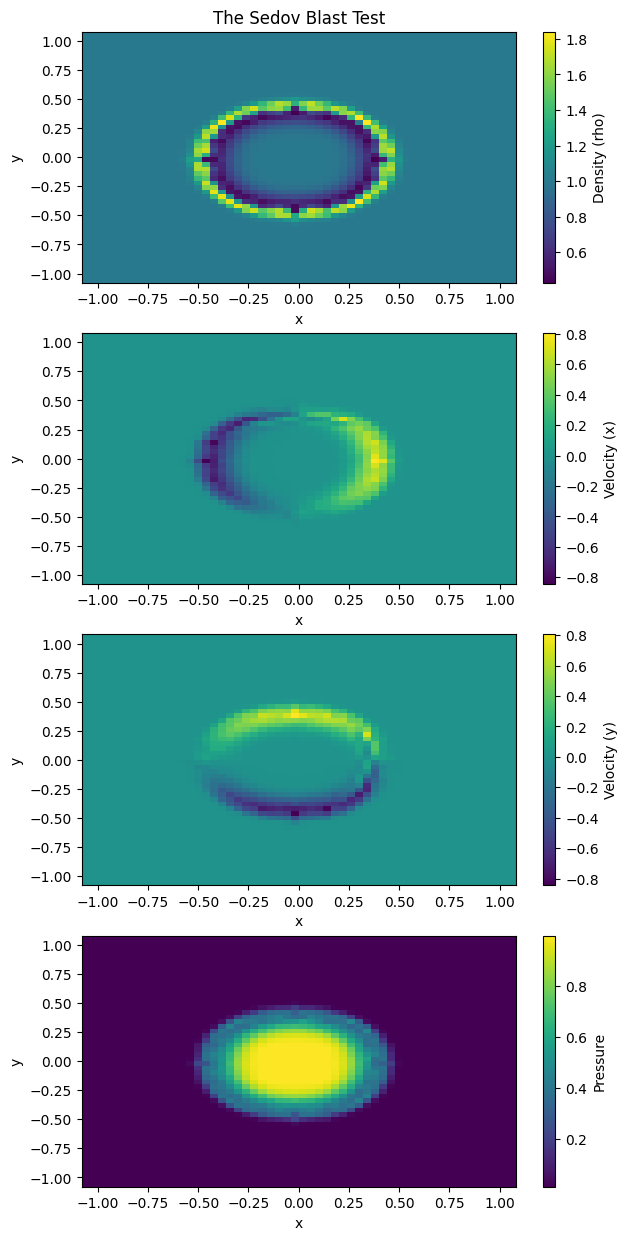

In [7]:
#plotting out the simulation

v = FluidVars()
# Assume g and U are the grid and state obtained from the solver in 2D
q = cons_to_prim(g, U)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7, 15))
cax1 = axes[0].pcolormesh(g.x , g.y , q[:, :,v.qrho], shading='auto', cmap='viridis')
fig.colorbar(cax1, ax=axes[0], label='Density (rho)')
axes[0].set_title('The Sedov Blast Test')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
cax2 = axes[1].pcolormesh(g.x, g.y, q[:, :, v.quy], shading='auto', cmap='viridis')
fig.colorbar(cax2, ax=axes[1], label='Velocity (x)')
axes[1].set_title('')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
cax3 = axes[2].pcolormesh(g.x, g.y, q[:, :, v.qux], shading='auto', cmap='viridis')
fig.colorbar(cax3, ax=axes[2], label='Velocity (y)')
axes[2].set_title('')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
cax4 = axes[3].pcolormesh(g.x, g.y, q[:, :, v.qp], shading='auto', cmap='viridis')
fig.colorbar(cax4, ax=axes[3], label='Pressure')
axes[3].set_title("")
axes[3].set_xlabel('x')
axes[3].set_ylabel('y')

#to save the figure
fig.savefig("50 resolution")